In [9]:
import os
import json
import math
import rasterio
from rasterio.plot import reshape_as_image
import rasterio.mask
from rasterio.features import rasterize
import matplotlib
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping, Point, Polygon
from shapely.ops import cascaded_union
import numpy as np
import PIL
import matplotlib.pyplot as plt


# Création d'un masque à partir du GeoJson et d'une liste de features

- Cette version traite une image à la fois. 
**V2 possible: prendre en entrée un fichier texte contenant les noms des cartes à traiter**
- On considère une liste donnée de feattypes donnée plus bas
- Le masque en sortie est un png de la même taille que le GeoTIFF en entrée, codé sur un canal 8 bits
- Si un pixel appartient à au moins deux objets, il prend la valeur de pixel somme 
**V2 possible: donner une règle de priorité entre les types d'objet: qui passe devant qui ? ex runway marking devant runwayelement.**


In [10]:
# A MODIFIER AVEC LES BONS CHEMINS POUR RUN LE CODE SUR VOTRE MACHINE

path_GeoTIFF = "/Users/salimbaddou/PIE/Airport_Feature_Auto_Detection/GeoTIFF/"
path_GeoJson = "/Users/salimbaddou/PIE/Airport_Feature_Auto_Detection/GeoJson/"
path_data = "/Users/salimbaddou/PIE/data2"

#image considérée
name_map = "VHHH"

#chemin de sortie pour le masque png
outfolder = "/Users/salimbaddou/PIE"  
os.makedirs(outfolder, exist_ok=True)

In [11]:
# Liste des features d'intérêt et color mapping (1 canal nuances de gris de 1 à 255, 0 est background)
color_mapping = {
    'Apron.apronelement': 1,
    'Runway.runwayelement': 2,
    'ServiceRoad.serviceroad': 3,
}
features_list = ['Apron.apronelement','Runway.runwayelement','ServiceRoad.serviceroad']

In [25]:
# Fonctions de création de masques par lecture du GeoJson
# TO DO: V2 qui gère la superposition d'objets. Idée: un petit objet inclut dans un autre doit avoir priorité sur l'affichage 

def poly_from_utm(polygon, transform):
    poly_pts = []
    
    # make a polygon from multipolygon
    poly = cascaded_union(polygon)
    for i in np.array(poly.exterior.coords):
        
        # transfrom polygon to image crs, using raster meta
        poly_pts.append(~transform * tuple(i))
        
    # make a shapely Polygon object
    new_poly = Polygon(poly_pts)
    return new_poly

# creating binary mask for field/not_filed segmentation.
def create_mask(features_list,src,df):
    nb_class=len(features_list)
    im_size = (src.meta['height'], src.meta['width'])
    whole_mask = np.zeros([src.meta['height'],src.meta['width']])

    for i,f in enumerate(features_list):
        poly_shp = []
        data_geom = df[df['feattype'] == {'value': f}].geometry
        for g in data_geom.values:

            poly = poly_from_utm(g, src.meta['transform'])
            poly_shp.append(poly)

            if g.geom_type == 'Polygon':
                poly = poly_from_utm(g, src.meta['transform'])
                poly_shp.append(poly)
            else:
                for p in g:
                    poly = poly_from_utm(p, src.meta['transform'])
                    poly_shp.append(poly)
        if poly_shp:
            mask = rasterize(shapes=poly_shp,out_shape=im_size)*color_mapping[f]
            #print(mask.shape)
            whole_mask = whole_mask + mask
           
    return whole_mask

def create_mask_multi_channel(features_list,src,df):
    nb_class=len(features_list) +1
    im_size = (src.meta['height'], src.meta['width'])
    whole_mask = np.zeros([src.meta['height'],src.meta['width'],nb_class])

    for i,f in enumerate(features_list):
        poly_shp = []
        data_geom = df[df['feattype'] == {'value': f}].geometry
        for g in data_geom.values:

            poly = poly_from_utm(g, src.meta['transform'])
            poly_shp.append(poly)

            if g.geom_type == 'Polygon':
                poly = poly_from_utm(g, src.meta['transform'])
                poly_shp.append(poly)
            else:
                for p in g:
                    poly = poly_from_utm(p, src.meta['transform'])
                    poly_shp.append(poly)
        if poly_shp:
            mask = rasterize(shapes=poly_shp,out_shape=im_size)*color_mapping[f]
            #print(mask.shape)
            whole_mask[:,:,i + 1] = mask
           
    return whole_mask


In [26]:
img_name = name_map+"_ortho.tif"
directory = os.fsencode(path_GeoTIFF)

for file in os.listdir(directory):
    
    filename = os.fsdecode(file)
    if filename==img_name:
        with rasterio.open(path_GeoTIFF+"{}".format(filename)) as src:
            img = src.read()
            meta = src.meta
            filepath = path_GeoJson+"product_ADBLucem_"+name_map+".json"
            df = polygon_df(filepath)
            
            whole_mask = create_mask_multi_channel(features_list,src,df)
            
        
            
            print(whole_mask.shape)
            
#             #Rescale to 0-255 and convert to uint8
#             rescaled = (255.0 / data.max() * (data - data.min())).astype(np.uint8)

            # Save numpy array into png mask 1 channel
            cv2.imwrite(outfolder + '/masktest6_{}.png'.format(img_name.split('_')[0]),whole_mask)


(12700, 19699, 4)


In [19]:
#for lirp IMG:

In [20]:
def crop_img_mask(filename):
    name = "LIRP" + str(np.random.randint(1,5000))
    print(name)
    with rasterio.open("{}{}_ortho.tif".format(path_GeoTIFF,filename)) as src:
        img = src.read()
    _,xs,ys = img.shape
    i = np.random.randint(1,100)
    i = i*10
    
    im_size = 512
    cut = np.random.randint(1,im_size - 30)
    
    
    
    #img = reshape_as_image(img):,i:i+im_size,j:j+im_size])
    img = reshape_as_image(img)
    img = img[4000 - i :5000- i,1000 + i:2001+ i]
    
    img = img[cut:cut+im_size,cut:cut+im_size]
    #print(img.shape)
    plt.imshow(img)
    
    
    matplotlib.image.imsave('{}/imgs/{}.png'.format(path_data,name), img)
    
    #change with path to the image you want to sample from
    with rasterio.open("/Users/salimbaddou/PIE/masktest_{}.png".format(filename)) as src:
        img = src.read()
        
    #print(img.shape)
        
    img = img[0,4000 - i :5000- i,1000 + i:2001+ i]
    img = img[cut:cut+im_size,cut:cut+im_size]
    #img =img[0,i:i+im_size,j:j+im_size]
    #img = img[0,i:i+500,i:i+500]
    print(img.shape)
    plt.imshow(img)
    
    cv2.imwrite('{}/masks/{}.png'.format(path_data,name), img)
    
    
    

In [ ]:
#set N to the number of sub-image you want

LIRP4321


/Users/salimbaddou/anaconda3/lib/python3.7/site-packages/rasterio/__init__.py:219: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


(512, 512)


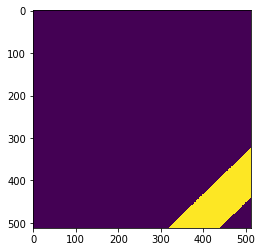

In [21]:
for i in range(N):
    crop_img_mask("LIRP")

In [ ]:
#sample image with normal centred distribution

In [27]:
def crop_img_mask(filename):
    name = "VHHH" + str(np.random.randint(1,10000))
    print(name)
    with rasterio.open("/Users/salimbaddou/PIE/Airport_Feature_Auto_Detection/GeoTIFF/{}_ortho.tif".format(filename)) as src:
        img = src.read()
    _,xs,ys = img.shape
    mean = (xs//2, ys//2)
    cov = [[100*xs, 0], [0, 100*ys]]
    x = np.random.multivariate_normal(mean, cov)
    print(int(x[0]))
    im_size = 512
    
    
    img = reshape_as_image(img)
    
    
    img = img[int(x[0]):int(x[0])+im_size,int(x[1]):int(x[1])+im_size]
    #print(img.shape)
    plt.imshow(img)
    
    
    matplotlib.image.imsave('{}/imgs/{}.png'.format(path_data,name), img)
    
    #change with path to the image you want to sample from
    with rasterio.open("/Users/salimbaddou/PIE/masktest6_{}.png".format(filename)) as src:
        img = src.read()
        
    
    print(img.shape)
    img = reshape_as_image(img)
    print(img.shape)
    img = img[int(x[0]):int(x[0])+im_size,int(x[1]):int(x[1])+im_size]
    
    print(img.shape)
    plt.imshow(img)
    
    cv2.imwrite('{}/masks/{}.png'.format(path_data,name), img)
    
    
    

VHHH4523
6318
(4, 12700, 19699)
(12700, 19699, 4)
(512, 512, 4)
VHHH3450
5591
(4, 12700, 19699)
(12700, 19699, 4)
(512, 512, 4)
VHHH6462
6158
(4, 12700, 19699)
(12700, 19699, 4)
(512, 512, 4)
VHHH7814
5597
(4, 12700, 19699)
(12700, 19699, 4)
(512, 512, 4)
VHHH9918
8701
(4, 12700, 19699)
(12700, 19699, 4)
(512, 512, 4)
VHHH1593
8467
(4, 12700, 19699)
(12700, 19699, 4)
(512, 512, 4)
VHHH1964
4317
(4, 12700, 19699)
(12700, 19699, 4)
(512, 512, 4)
VHHH7472
7538
(4, 12700, 19699)
(12700, 19699, 4)
(512, 512, 4)
VHHH1445
4612
(4, 12700, 19699)
(12700, 19699, 4)
(512, 512, 4)
VHHH3715
5672
(4, 12700, 19699)
(12700, 19699, 4)
(512, 512, 4)
VHHH8439
5947
(4, 12700, 19699)
(12700, 19699, 4)
(512, 512, 4)
VHHH55
5990
(4, 12700, 19699)
(12700, 19699, 4)
(512, 512, 4)
VHHH5072
7172
(4, 12700, 19699)
(12700, 19699, 4)
(512, 512, 4)
VHHH4746
7697
(4, 12700, 19699)
(12700, 19699, 4)
(512, 512, 4)
VHHH1528
7301
(4, 12700, 19699)
(12700, 19699, 4)
(512, 512, 4)
VHHH4882
6343
(4, 12700, 19699)
(12700, 19

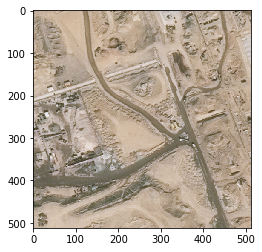

In [70]:
for i in range(80):
    crop_img_mask("VHHH")

# OLD: exploration et manipulation d'un GeoJson

### Open image with rasterio:

In [ ]:
with rasterio.open(path_GeoTIFF+"/"+name_map+"_ortho.tif") as src:
    img = src.read()
    meta = src.meta

img = reshape_as_image(img)



### Read Geojson as  a dataframe:

In [8]:
def polygon_df(filepath):
    df = gpd.read_file(filepath)
    df = df.drop(columns=['originated', 'readonly',
           'notvalidated', 'lock', 'elev', 'hacc', 'iata', 'name', 'idarpt',
           'acft', 'idnumber', 'termref', 'pcn', 'restacft', 'status', 'surftype',
           'length', 'width', 'color', 'direc', 'style', 'rwymktyp', 'asda',
           'availPavedSurfFromThr', 'brngmag', 'brngtrue', 'cat', 'ellipse',
           'geound', 'lda', 'rops_landing_length', 'rwyslope', 'tdze', 'tdzslope',
           'thrtype', 'toda', 'tora', 'vasis', 'bridge', 'gsurftyp', 'runwayexit',
           'imagery_date'])
    
    return df[df["geometry"].geom_type == 'Polygon']

#### Only polygon:

In [12]:
df = polygon_df(path_GeoJson+"/product_ADBLucem_"+name_map+".json")
df.head()

,id,feattype,label_id,name_id,aprontyp,pendate,piocdate,pstdate,docking,fuel,...,featbase,wingspan,maxspeed,catstop,idlin,rwyahtxt,height,material,plysttyp,geometry
1,ALLADB|ADBLucem|apronelement|86413,{'value': 'Apron.apronelement'},{'value': '$UNK'},{'value': '$UNK'},{'value': None},None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,"POLYGON ((113.91412 22.29822, 113.91424 22.297..."
2,ALLADB|ADBLucem|apronelement|86414,{'value': 'Apron.apronelement'},{'value': '$UNK'},{'value': '$UNK'},{'value': None},None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,"POLYGON ((113.90202 22.29498, 113.90219 22.295..."
3,ALLADB|ADBLucem|apronelement|86415,{'value': 'Apron.apronelement'},{'value': 'BUSINESS AVIATION CENTRE APRON'},{'value': 'BUSINESS AVIATION CENTRE APRON'},{'value': None},None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,"POLYGON ((113.91129 22.29718, 113.91127 22.297..."
4,ALLADB|ADBLucem|apronelement|86416,{'value': 'Apron.apronelement'},{'value': 'BUSINESS AVIATION CENTRE APRON'},{'value': 'BUSINESS AVIATION CENTRE APRON'},{'value': None},None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,"POLYGON ((113.91155 22.29679, 113.91115 22.296..."
5,ALLADB|ADBLucem|apronelement|86417,{'value': 'Apron.apronelement'},{'value': 'WEST CARGO APRON'},{'value': 'WEST CARGO APRON'},{'value': None},None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,"POLYGON ((113.90572 22.30758, 113.90517 22.309..."


### Liste des features contenues dans le GeoJSON

In [13]:
features_list = []
for e in df['feattype']:
    if e['value'] not in features_list:
        features_list.append(e['value'])

print(features_list)

['Apron.apronelement', 'ConstructionArea.constructionarea', 'ParkingStandArea.parkingstandarea', 'Runway.runwaydisplacedarea', 'Runway.runwayelement', 'Runway.runwaymarking', 'Runway.runwayshoulder', 'ServiceRoad.serviceroad', '0', 'Taxiway.taxiwayshoulder', 'TouchDownLiftOffArea.touchdownliftoffarea', 'VerticalStructure.verticalpolygonalstructure', 'Water.water']


In [14]:
np.unique(np.array(PIL.Image.open("/Users/salimbaddou/PIE/masktest3_VHHH.png")))

DecompressionBombError: Image size (250177300 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.

In [59]:
with rasterio.open("/Users/salimbaddou/PIE/data2/masks/VHHH8181.png") as src:
    img = src.read()

img[:][:][:].max()



3

In [ ]:
/Users/salimbaddou/Desktop/Pytorch-UNet-master-2/data/masks
/Users/salimbaddou/PIE/data2/masks/VHHH1077.png

In [74]:
path = "/Users/salimbaddou/Desktop/Pytorch-UNet-master-2/data2/masks/"
dirs = os.listdir( path )


for item in dirs:
    if os.path.isfile(path+item):
        print(item)
        


VHHH5190.png
VHHH9436.png
VHHH3286.png
VHHH4070.png
VHHH9434.png
VHHH8919.png
VHHH4474.png
VHHH5030.png
VHHH7814.png
VHHH7140.png
VHHH3865.png
VHHH915.png
VHHH1445.png
VHHH9757.png
VHHH1051.png
VHHH55.png
.DS_Store
VHHH3450.png
VHHH5746.png
VHHH9168.png
VHHH3109.png
VHHH4882.png
VHHH5222.png
VHHH5430.png
VHHH1655.png
VHHH6462.png
VHHH9642.png
VHHH1593.png
VHHH356.png
VHHH9523.png
VHHH3026.png
VHHH3782.png
VHHH6760.png
VHHH3036.png
VHHH7907.png
VHHH8439.png
VHHH568.png
VHHH9280.png
VHHH1743.png
VHHH4820.png
VHHH1964.png
VHHH8954.png
VHHH9861.png
VHHH7535.png
VHHH3545.png
VHHH9918.png
VHHH6961.png
VHHH4385.png
VHHH4967.png
VHHH3173.png
VHHH5072.png
VHHH638.png
VHHH7472.png
VHHH3628.png
VHHH5275.png
VHHH9658.png
VHHH6966.png
VHHH6027.png
VHHH1006.png
VHHH4746.png
VHHH3389.png
VHHH1944.png
VHHH2530.png
VHHH6420.png
VHHH6335.png
VHHH1894.png
VHHH3715.png
VHHH658.png
VHHH2344.png
VHHH5167.png
VHHH4523.png
VHHH2187.png
VHHH7202.png
VHHH2814.png
VHHH8915.png
VHHH1528.png
VHHH6871.png
VHHH5175.